In [1]:
# Installation
!pip install -q segmentation_models 
!pip install -q numpy==1.19.5

In [2]:
import os
import random
import glob
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.metrics import MeanIoU
from keras.utils.np_utils import to_categorical
import segmentation_models as sm
from matplotlib import pyplot as plt

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [14]:
height = 256
width = 256

num_classes = 9
random_state = 8
test_size = 0.2

path = '/content/dataset/'
image_dir = path+'images/'
mask_dir = path+'masks/'

activation='softmax'
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate)
batch_size=8
epochs=200

backbone = 'resnet101'
encoder_weights='imagenet'
input_shape=(height,width,3)

focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = (1 * focal_loss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [15]:
# load images
images= []
files = glob.glob(image_dir+'/**.jpg')
files.sort()
for f in files:
    img = cv2.imread(f, 1)
    img = cv2.resize(img, (height, width), interpolation = cv2.INTER_NEAREST)
    images.append(img)

images  = np.array(images)
print('Images: ', images.shape)

Images:  (86, 256, 256, 3)


In [16]:
# load masks
masks = []
files = glob.glob(mask_dir+'/**.jpg')
files.sort()
for f in files:
    img = cv2.imread(f, 0)
    img = cv2.resize(img, (height, width), interpolation = cv2.INTER_NEAREST)
    masks.append(img)

masks  = np.array(masks)
print('Masks: ', masks.shape)

Masks:  (86, 256, 256)


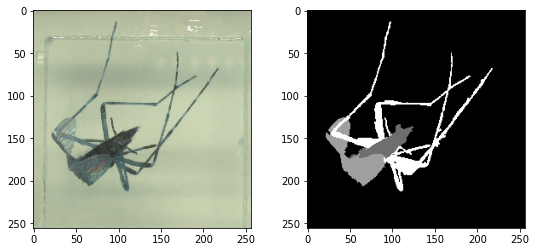

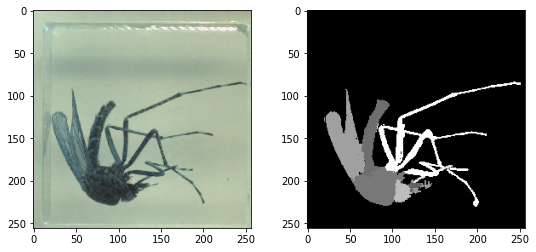

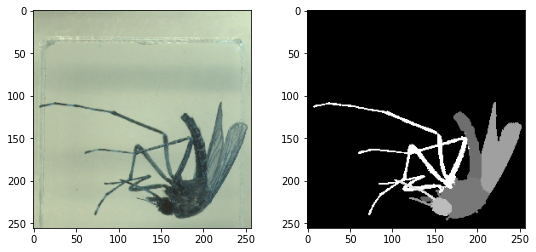

In [17]:
i = random.randint(0, len(images)-1)

for i in range(3):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plt.imshow(images[i,:,:,:])

    plt.subplot(122)
    plt.imshow(masks[i,:,:], cmap='gray')

    plt.show()

In [20]:
def preprocess(backbone, images, masks):
        # label encoding
  labelencoder = LabelEncoder()
  n, h, w = masks.shape

  print("Labels Original: ", np.unique(masks))

  masks_encoded = masks.reshape(-1,1)
  masks_encoded = labelencoder.fit_transform(masks_encoded)
  masks_encoded = masks_encoded.reshape(n, h, w)

  labels_encoded = np.unique(masks_encoded)
  print("Labels Encoded: ", labels_encoded)
  print("Labeled Classes: ", len(np.unique(labels_encoded)))

        # cetegorical
  masks_input = np.expand_dims(masks_encoded, axis=3)

        # train test split
  X_train, X_test, y_train, y_test = train_test_split(images, masks_input, test_size=test_size, random_state=random_state)

        # convert labels to categorical
  y_train_labels = to_categorical(y_train, num_classes=num_classes)
  y_test_labels = to_categorical(y_test, num_classes=num_classes)

  y_train_labels = y_train_labels.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], num_classes))
  y_test_labels = y_test_labels.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], num_classes))

        # backbone preprocessing
  preprocess = sm.get_preprocessing(backbone)
  X_train_new = preprocess(X_train)
  X_test_new = preprocess(X_test)

  print("X_train.shape:", X_train_new.shape)
  print("X_test.shape:", X_test_new.shape)
  print("y_train.shape:", y_train_labels.shape)
  print("y_test.shape:", y_test_labels.shape)

  return X_train_new, X_test_new, y_train_labels, y_test_labels

In [21]:
def build_model(backbone):
  model = sm.FPN(backbone, encoder_weights=encoder_weights, input_shape=input_shape, classes=num_classes, activation=activation)
  model.compile(optimizer, total_loss, metrics=metrics)
  print(model.summary())
  return model

In [28]:
def train_model(model, X_train, X_test, y_train, y_test):
  class MyCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
      print(logs.get('iou_score'))
      if(logs.get('iou_score') > 0.90):
        self.model.stop_training = True
  result = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test),
                            callbacks=[MyCallback()])

  return result

In [24]:
def visualize_model(history):
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  acc = history['iou_score']
  val_acc = history['val_iou_score']
  plt.plot(epochs, acc, 'y', label='Train IOU')
  plt.plot(epochs, val_acc, 'r', label='Validation IOU')
  plt.title('Training and validation IOU')
  plt.xlabel('Epochs')
  plt.ylabel('Mean IOU')
  plt.legend()
  plt.show()
  acc = history['f1-score']
  val_acc = history['val_f1-score']
  plt.plot(epochs, acc, 'y', label='Train F1-score')
  plt.plot(epochs, val_acc, 'r', label='Validation F1-score')
  plt.title('Training and validation F1-score')
  plt.xlabel('Epochs')
  plt.ylabel('Mean F1-score')
  plt.legend()
  plt.show()

In [25]:
X_train, X_test, y_train, y_test = preprocess('resnet101', images, masks)

Labels Original:  [  0  81  91  99 127 132 155 189 211]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Labels Encoded:  [0 1 2 3 4 5 6 7 8]
Labeled Classes:  9
X_train.shape: (68, 256, 256, 3)
X_test.shape: (18, 256, 256, 3)
y_train.shape: (68, 256, 256, 9)
y_test.shape: (18, 256, 256, 9)


In [26]:
model = build_model('resnet101')

171180032/171164896 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)          

In [29]:
result = train_model(model, X_train, X_test, y_train, y_test)

Epoch 1/200
9/9 [==============================] - 30s 704ms/step - loss: 0.0212 - accuracy: 0.7601 - iou_score: 0.0804 - f1-score: 0.0970 - val_loss: 0.2659 - val_accuracy: 0.1295 - val_iou_score: 0.0169 - val_f1-score: 0.0301
Epoch 2/200
9/9 [==============================] - 2s 262ms/step - loss: 0.0049 - accuracy: 0.9119 - iou_score: 0.1093 - f1-score: 0.1179 - val_loss: 0.0465 - val_accuracy: 0.8960 - val_iou_score: 0.0993 - val_f1-score: 0.1049
Epoch 3/200
9/9 [==============================] - 2s 263ms/step - loss: 0.0036 - accuracy: 0.9232 - iou_score: 0.1320 - f1-score: 0.1514 - val_loss: 0.0451 - val_accuracy: 0.8970 - val_iou_score: 0.0994 - val_f1-score: 0.1050
Epoch 4/200
9/9 [==============================] - 3s 283ms/step - loss: 0.0028 - accuracy: 0.9346 - iou_score: 0.1867 - f1-score: 0.2327 - val_loss: 0.0362 - val_accuracy: 0.9005 - val_iou_score: 0.1018 - val_f1-score: 0.1086
Epoch 5/200
9/9 [==============================] - 2s 263ms/step - loss: 0.0025 - accuracy:

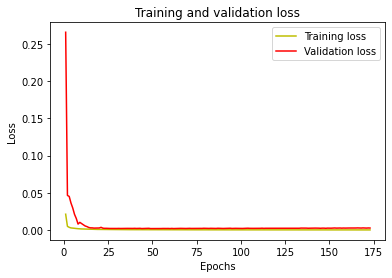

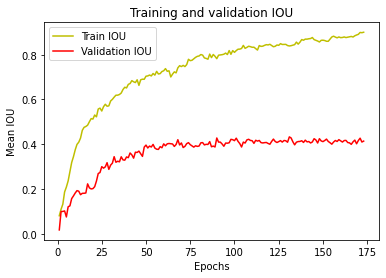

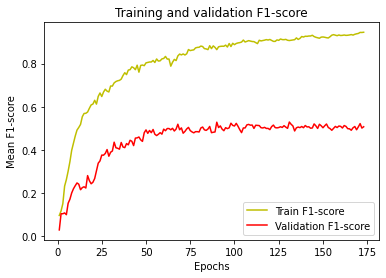

In [30]:
visualize_model(result.history)

In [31]:
X_train, X_test, y_train, y_test = preprocess('resnet101', images, masks)

Labels Original:  [  0  81  91  99 127 132 155 189 211]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Labels Encoded:  [0 1 2 3 4 5 6 7 8]
Labeled Classes:  9
X_train.shape: (68, 256, 256, 3)
X_test.shape: (18, 256, 256, 3)
y_train.shape: (68, 256, 256, 9)
y_test.shape: (18, 256, 256, 9)


In [32]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

print('y_predict.shape: ', y_pred.shape)
print('y_predict_argmax.shape: ', y_pred_argmax.shape)

mean_iou = MeanIoU(num_classes=num_classes)  
mean_iou.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", mean_iou.result().numpy())

y_predict.shape:  (18, 256, 256, 9)
y_predict_argmax.shape:  (18, 256, 256)
Mean IoU = 0.0010080787


In [33]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_train_argmax = np.argmax(y_train, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

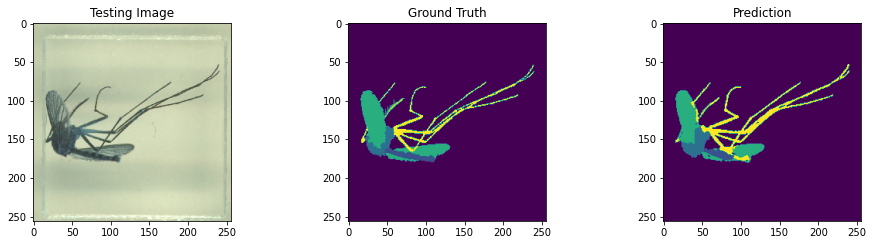

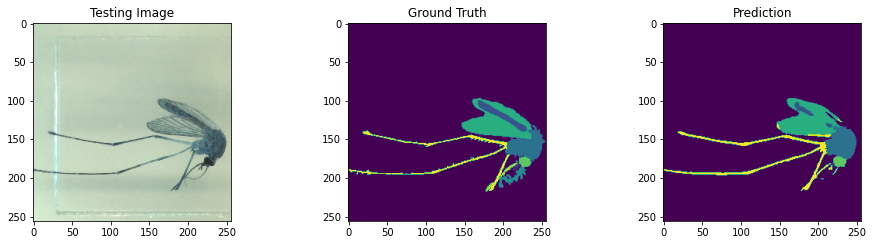

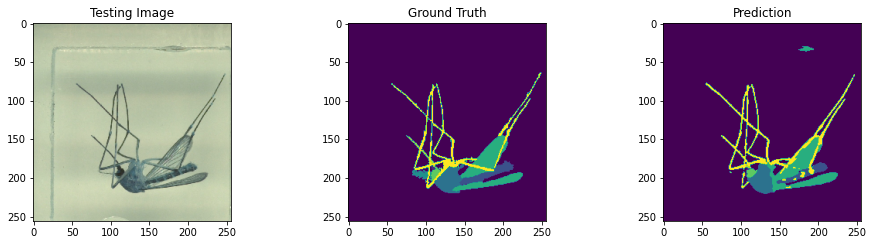

In [34]:
for i in range(3):
  r = random.randint(0, len(X_test)-1)
  test_img = X_test[r]
  ground_truth = y_test_argmax[r]
  test_img_input = np.expand_dims(test_img,0)
  prediction = (model.predict(test_img_input))
  prediction_image = np.argmax(prediction, axis=3)[0,:,:]
  img = test_img
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img, cmap='gray')
  plt.subplot(232)
  plt.title('Ground Truth')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction')
  plt.imshow(prediction_image)
  plt.show()